# Import Libraries
Apart from standard libraries, I am one custom module "custom_transformations".

In [18]:

import numpy as np
import pandas as pd
from baikal import make_step, Step, Input, Model
from baikal.steps import Stack
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.linear_model import ElasticNet, LinearRegression
from xgboost import XGBRegressor

from sklearn_pandas import gen_features
from sklearn.impute import MissingIndicator, SimpleImputer
from category_encoders import TargetEncoder

from custom_transformations import ConcatDataFrame, DataFrameMapperStep, CatBoostRegressorStep

# Define DAG

In [19]:
data = pd.read_csv('data/train.csv')

In [20]:
# these are the categorical columns in the dataset
CATEGORICAL_COLUMNS = [
    'KitchenQual', 'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
    'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
    'Heating', 'HeatingQC', 'CentralAir', 'Functional', 'FireplaceQu', 'GarageType', 
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 
    'SaleCondition',
    'OverallQual', 'OverallCond',
]

# these columns will be terated as a numerical columns
NUMERICAL_COLUMNS = [
    'LotFrontage', 'LotArea', 'YearBuilt', 
    'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
    'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'
]


# These columns have missing values and the one for which we will add missing indicator variable
MISSING_INDICATOR = [
    'LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]

## Categorical Columns for which we want One Hot Encoding
ONEHOT_COLUMNS = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 
    'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
    'SaleType', 'SaleCondition'
]

## Categorical Columns for which we want to have target encoding
TARGET_COLUMNS = [
    'MSSubClass', 'Neighborhood', 'Exterior1st', 'Exterior2nd'
]

## Columns for that require log transformations
LOG_COLUMNS = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]

In [21]:
# Define Steps 
ElasticNetStep = make_step(ElasticNet, class_name='ElasticNet')
ConcatStep = make_step(ct.ConcatDataFrame, class_name='Concat')
XGBRegressorStep = make_step(XGBRegressor, class_name='XGBRegressor')
LinearRegressionStep = make_step(LinearRegression, class_name='LinearRegression')

# Define sklearn-pandas transformations. Here I am using gen_features utility to 
# define transformations for individual columns. 
baseProcessing = (
    gen_features(
        columns=[[x] for x in MISSING_INDICATOR],
        classes = [
            {'class': MissingIndicator, 'features': 'all', 'sparse': False, 'error_on_new': False}
        ], 
        prefix = 'na_'
    ) +
    gen_features(
        columns=LOG_COLUMNS,
        classes=[
            {'class': FunctionTransformer, 'func': lambda x: x.astype(np.float).reshape((-1, 1))},
            {'class': SimpleImputer, 'strategy': 'mean'},
            {'class': FunctionTransformer, 'func': np.log1p}            
        ]
    ) +
    gen_features(
        columns=list(set(NUMERICAL_COLUMNS) - set(LOG_COLUMNS)),
        classes=[
            {'class': FunctionTransformer, 'func': lambda x: x.astype(np.float).reshape((-1, 1))},
            {'class': SimpleImputer, 'strategy': 'mean'}
        ],
    ) + 
    [
        # constructing new features -- age of the house
        (
            ['YrSold', 'YearBuilt'], 
            [
                FunctionTransformer(func=lambda x: np.clip(x[:,0] - x[:,1], 0, 1000)), 
                FunctionTransformer(np.log1p)
            ], 
            {'alias': 'age'}
        ),

        # constructing new feature -- remodeling age
        (
            ['YrSold', 'YearRemodAdd'], 
            [
                FunctionTransformer(func=lambda x: np.clip(x[:,0] - x[:,1], 0, 1000)), 
                FunctionTransformer(np.log1p)
            ], 
            {'alias': 'remodel_age'}
        ),

        # new feature -- total surface area
        (
            ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], 
            [
                FunctionTransformer(lambda x: np.nansum(x, axis=1)), 
                FunctionTransformer(np.log1p)
            ], 
            {'alias': 'numerical_TotalArea'}
        )
    ]
)

# Since CatBoost model can handle categorical data, we don't need to encode categorical variables
# we will simply impute missing values and let CatBoost model handle categorical data. 
catModelPreprocessing = gen_features(
    columns=CATEGORICAL_COLUMNS,
    classes = [
        {'class': FunctionTransformer, 'func': lambda x: x.astype(np.object).reshape(-1, 1)},
        {'class': SimpleImputer, 'strategy': 'most_frequent'}
    ],
)

# for regression and XGBoost, we will need to encode categorical variables ourselfs. 
# Depending on the cardinality of the variable, I am either using one hot encoding or target encoding. 
regressionModelProcessing = (
     gen_features(
        columns=[[x] for x in ONEHOT_COLUMNS],
        classes = [
            {'class': OneHotEncoder, 'handle_unknown': 'ignore', 'sparse': False}
        ]
    ) + 
    gen_features(
        columns=[[x] for x in TARGET_COLUMNS],
        classes = [
            {'class': TargetEncoder},
            {'class': SimpleImputer, 'strategy': 'mean'},
        ]     
    )
)
    
# Define DAG 
x = Input(name="x")
y = Input(name='y')

# Define feature transformations
d0 = DataFrameMapperStep(baseProcessing, df_out=True, name='BasePreprocess')(x, y)
d1 = DataFrameMapperStep(regressionModelProcessing, df_out=True, name='RegressionModelPreprocess')(x, y)
d2 = DataFrameMapperStep(catModelPreprocessing, df_out=True, name='CatModelPreprocess')(x, y)

# Consolidate features for catboost and elasticnet
regressionFeatures = ConcatStep(name='RegressionFeatures')([d0, d1])
catFeatures = ConcatStep(name='CatBoostFeatures')([d0, d2])

# Generate predictions using three different algorithms.
m1 = ElasticNetStep(name='ElasticNet')(regressionFeatures, y)
m2 = XGBRegressorStep(name='XGBoost')(regressionFeatures, y)
m3 = CatBoostRegressorStep(name='CatBoost', cat_features=CATEGORICAL_COLUMNS, iterations=10)(catFeatures, y)

# combine predictions from the three models
combinedPredictions= Stack(name='CombinePredictions')([m1, m3])

# construct an ensemble model
ensembleModel = LinearRegressionStep()(combinedPredictions, y)
model = Model(x, ensembleModel, y)
model.fit(data, data['SalePrice'])

# serialize model
import cloudpickle
with open('resources/model.pkl', 'wb+') as fp:
    cloudpickle.dump(model, fp)

Learning rate set to 0.5
0:	learn: 57389.6871258	total: 7.07ms	remaining: 63.7ms
1:	learn: 44136.9296879	total: 12.7ms	remaining: 50.9ms
2:	learn: 36475.8236139	total: 18.6ms	remaining: 43.5ms
3:	learn: 32041.5481119	total: 24.6ms	remaining: 36.9ms
4:	learn: 28632.3640828	total: 30ms	remaining: 30ms
5:	learn: 26945.3742191	total: 35.3ms	remaining: 23.5ms
6:	learn: 26466.6534465	total: 40.8ms	remaining: 17.5ms
7:	learn: 25441.1499243	total: 46ms	remaining: 11.5ms
8:	learn: 24424.4891571	total: 51.3ms	remaining: 5.7ms
9:	learn: 23421.2284352	total: 56.7ms	remaining: 0us


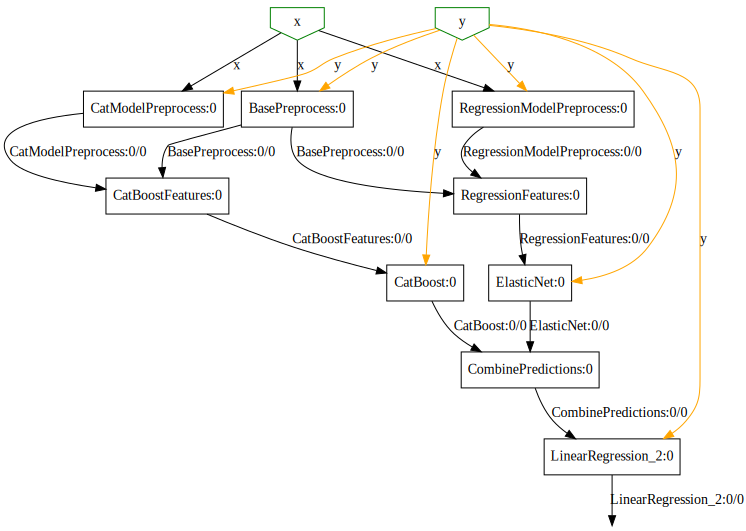

In [22]:
from baikal.plot import plot_model
from IPython.display import SVG
plot_model(model, filename='resources/model.svg')
SVG('resources/model.svg')